# Predicting Diabetes 

This analysis aims to determine if an individual has diabetes or not, which constitutes a binary classification task. In the context of medical diagnoses, attention must be equally distributed between recall and precision as both are crucial metrics (Lu et al., 2020). Recall measures the proportion of actual positives correctly identified, indicating the instances where the model incorrectly labels patients as non-diabetic when they are diabetic. Precision, meanwhile, gauges the fraction of true positives among all positive predictions, highlighting situations where the model incorrectly suggests diabetes, potentially leading to unnecessary treatments. However, the repercussions of overlooking a true positive—failing to diagnose a diabetic person—are significantly more severe than false positives. Missing a diabetic diagnosis means delayed treatment, with potentially dire health implications. Consequently, the analysis prioritizes both the F1-score, which balances precision and recall, and particularly emphasizes recall to mitigate the risks of non-detection of diabetes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 

## downloading the resources

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


**ASSIGNING VARIABLE NAMES**:

1. Number of times pregnant. (A)--> **pregnancies**
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test. (B) --> **glucose**
3. Diastolic blood pressure (mm Hg). (C)-->**blood_pressure**
4. Triceps skinfold thickness (mm). (D)-->**skin_thickness**
5. 2-Hour serum insulin (mu U/ml). (E)-->**insulin**
6. Body mass index (weight in kg/(height in m)^2). (F)-->**body_mass_index**
7. Diabetes pedigree function. (G)-->**diabetes_pedigree_function**
8. Age (years). (H)-->**age**
9. Class variable (0 or 1). (I)-->**output**

In [3]:
variables = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
             'insulin', 'body_mass_index', 'diabetes_pedigree_function',
             'age', 'output']

# Rename the columns
df.columns = variables

In [4]:
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,body_mass_index,diabetes_pedigree_function,age,output
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pregnancies                 767 non-null    int64  
 1   glucose                     767 non-null    int64  
 2   blood_pressure              767 non-null    int64  
 3   skin_thickness              767 non-null    int64  
 4   insulin                     767 non-null    int64  
 5   body_mass_index             767 non-null    float64
 6   diabetes_pedigree_function  767 non-null    float64
 7   age                         767 non-null    int64  
 8   output                      767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.shape

(767, 9)

the dataset is composed of 767 different cases (person) and 9 variables

In [7]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,body_mass_index,diabetes_pedigree_function,age,output
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,79.903520,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,115.283105,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From the summary it is already possible to notice that scaling the features is needed, since they differ a lot in terms of minimum and maximum values, and for some of them (such as pregnancies, glucose, insulin, etc.) the maximum value is also very distant from the values within the third quartile.

--> To have a better understanding let's look at the **Boxplot** for each feature

In [8]:
# Select the columns 
selected_columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
             'insulin', 'body_mass_index', 'diabetes_pedigree_function',
             'age']
selected_features = df[selected_columns]

# Convert selected features to long format 
df_long = pd.melt(selected_features, var_name='Feature', value_name='Value')

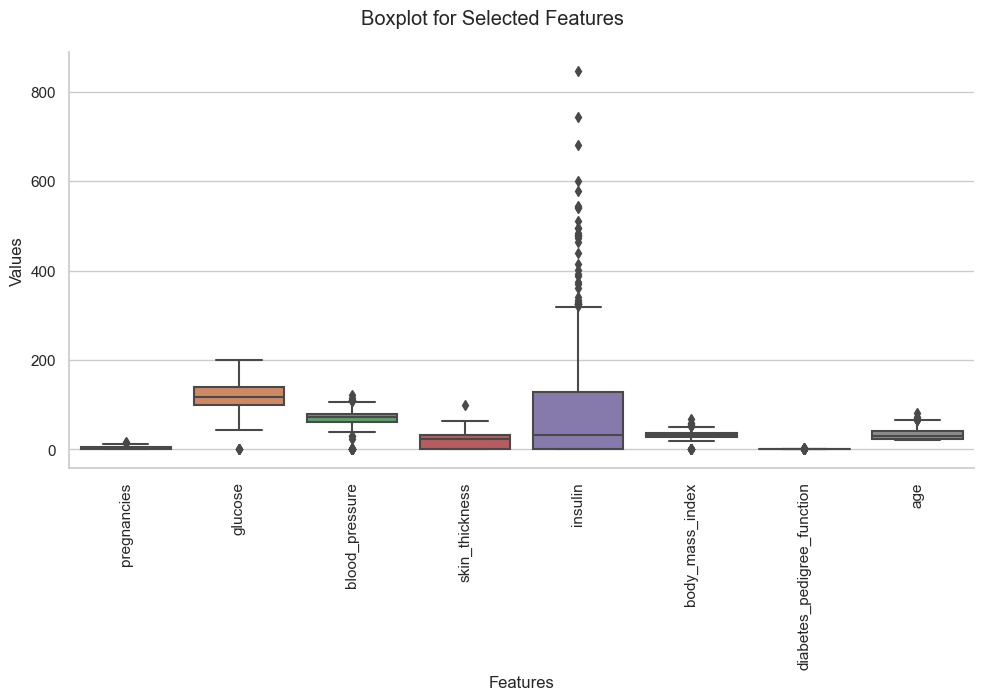

In [9]:
# boxplots 
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
g = sns.catplot(x="Feature", y="Value", kind="box", data=df_long, height=5, aspect=2)
g.set_xticklabels(rotation=90)
#g.set_titles("Boxplot for Selected Features")
g.set_axis_labels("Features", "Values")

g.fig.suptitle("Boxplot for Selected Features", y=1.05)
plt.show()

**BOXPLOT INTERPRETATION:**
- **Need for Scaling**, which is evident by the varying widths of the boxes and the range of values on the y-axis. The insuline, for example, has values that go up to 800, while diabetes_pedigree_function has a much smaller range. When features have different scales like this, it can disproportionately influence a model. Therefore, apply a scaling technique on these features is necessary before using them in a classification model.
- **Outlier consideration**. The boxplots also provide insights into the presence of outliers in the data. Outliers are data points that are significantly different from the majority of the data and can be atypical or erroneous. Outliers can impact the performance of classification models, especially those sensitive to data range and distribution, such as logistic regression. Proper handling of outliers may be necessary.
- **Skeweness Detection**. The position of the median line within each box can indicate the skewness of the feature's distribution. A median line closer to the bottom of the box suggests a right-skewed distribution, while a median closer to the top suggests a left-skewed distribution. Skewed data can potentially introduce biases in a model's performance, as models may assume a normal distribution of the data.

#### Distribution of the **output** variable

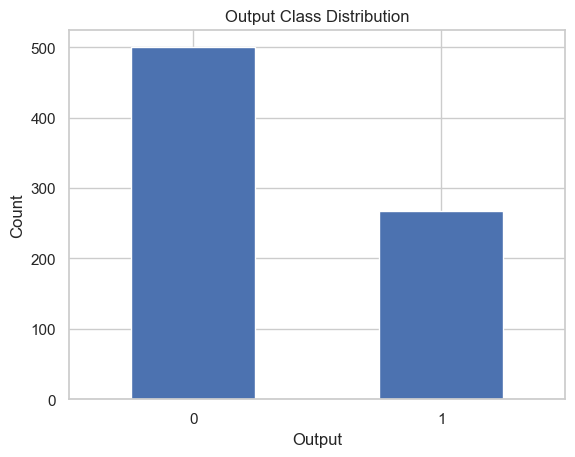

In [10]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
df["output"].value_counts().plot(kind="bar", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

# Set plot labels and title
ax.set_title("Output Class Distribution")
ax.set_xlabel("Output")
ax.set_ylabel("Count")

plt.show()

In [11]:
# occurrence of 0 and 1 values
count = df['output'].value_counts()

print("number of rows with 0:", count[0])
print("number of rows with 1:", count[1])

number of rows with 0: 500
number of rows with 1: 267


From the distribution of the 'output' feature it is possible to see that the dataset is **unbalanced** toward the 0 class. If the target variable in a classification model is unbalanced this can lead the model to be biased towards predicting the majority class, as it will have  more examples of this class to learn from during training. This can result in a high overall accuracy, but poor classification performance for the minority class. In this situation where the aim of the analysis is to diagnose if a person has diabetes or not, the cost of false negatives is high. Therefore having an imbalanced dataset can lead to high costs if the model fails to identify the important but rare events; and this has lead also to the decision of evaluating the model not only on the 'accuracy' performance metric.

### Variables distribution

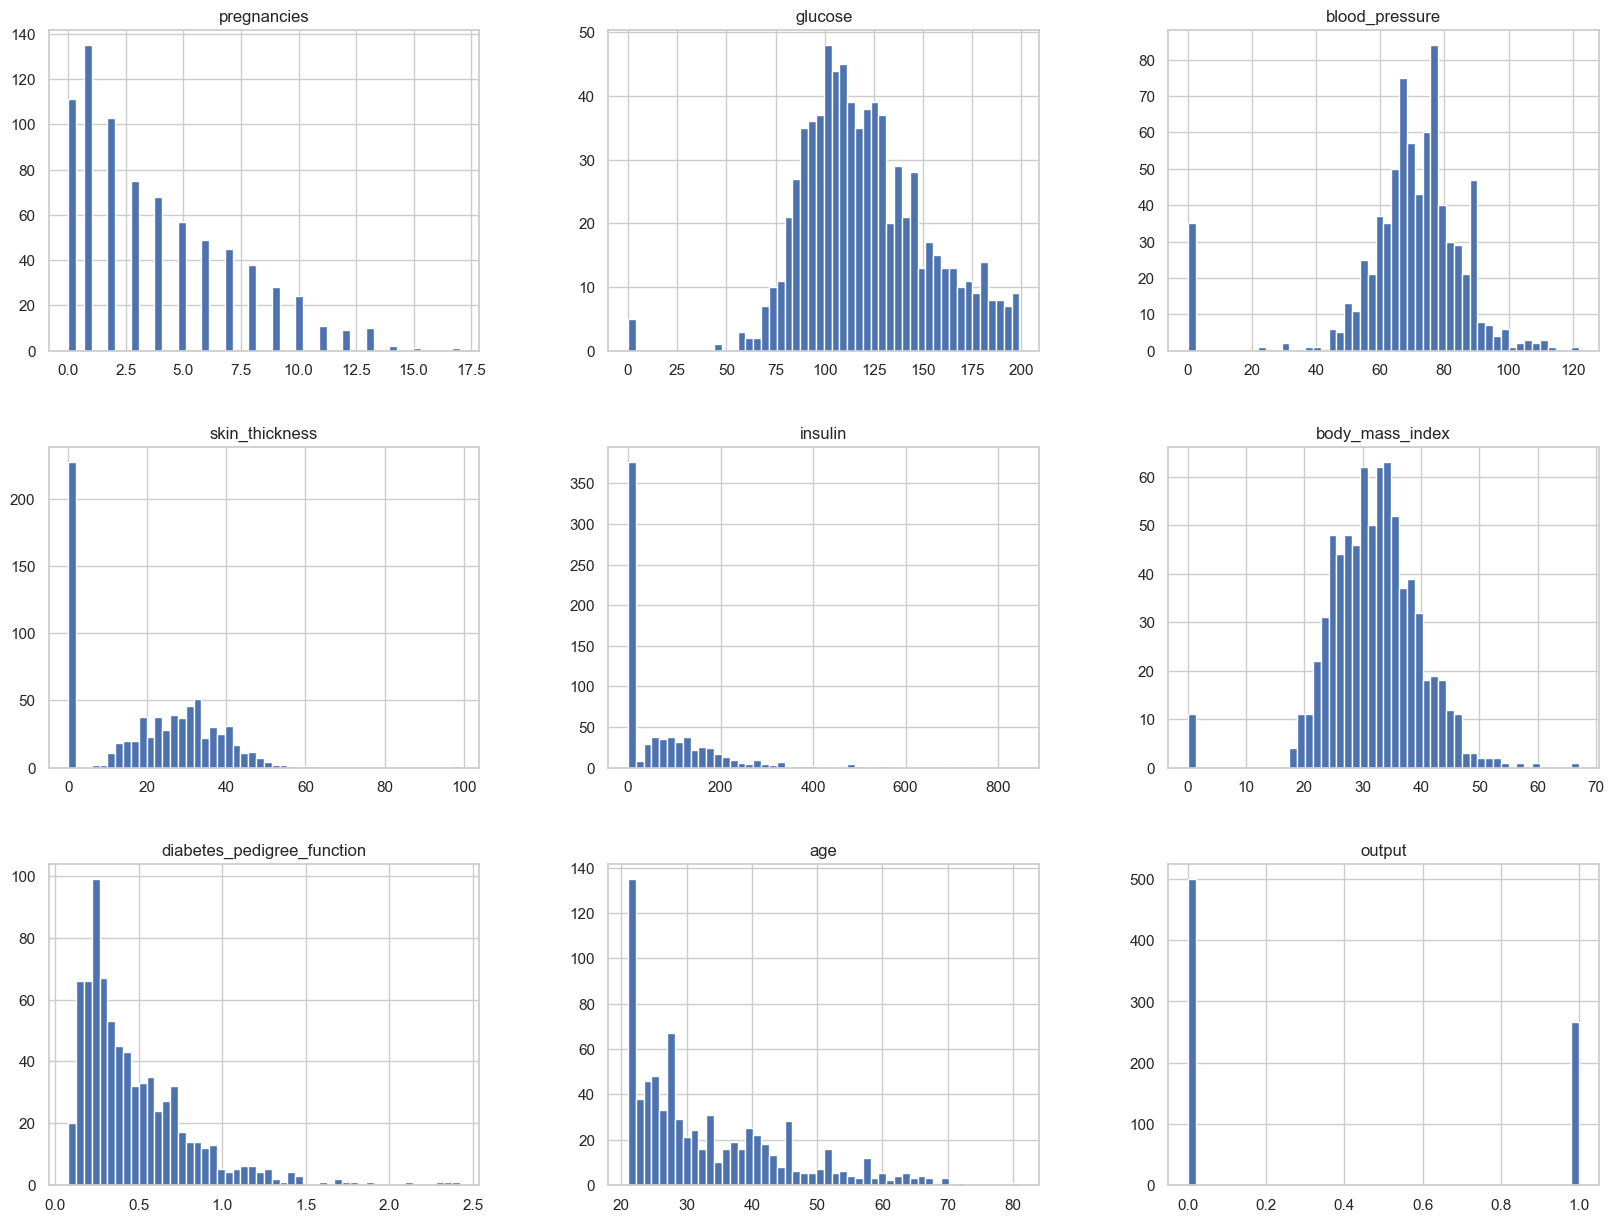

In [12]:
df.hist(bins=50, figsize=(20,15))
plt.show()

**Considerations from these histograms:**
- Some distributions are quite normal (blood_pressure, body_mass_index, glucose). Displaying a roughly normal distribution suggest that the data are evenly spread around the mean value.
- Some distributions are right skewed (pregnancies, age, diabetes_pedigree_function) implying that the majority of observations fall towards the lower end of the range.
- Many distributions has a lot of zero values. It is fundamental to notice that for some features like pregnancies a 0 value make sense, while for others like glucose, blood_pressure, skin_thickness, Insulin and body_mass_index would indicate missing or erroneous data, since do not make sense in a physiological context.

### Correlation between variables

<Figure size 1200x1000 with 0 Axes>

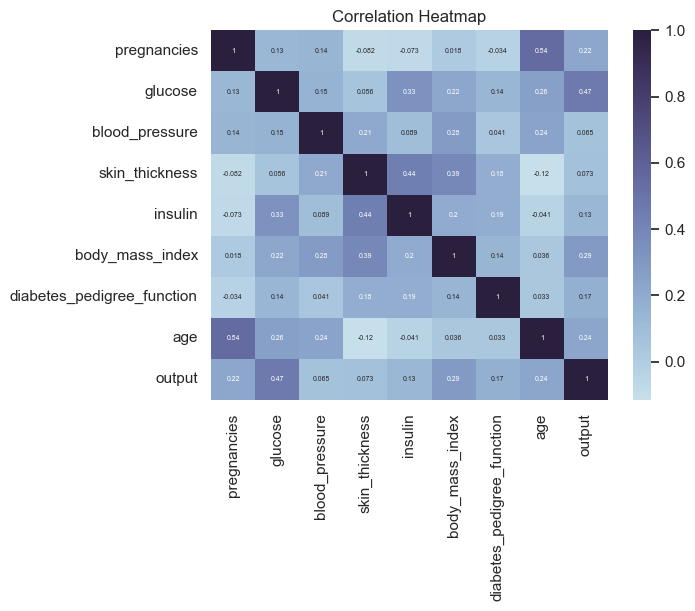

In [13]:
corr_df = df.corr()

# Correlation heatmap 
plt.figure(figsize=(12, 10))

fig, ax = plt.subplots()
sns.heatmap(corr_df, annot=True, cmap=sns.color_palette('ch:s=.25,rot=-.25', as_cmap=True), ax=ax, annot_kws={"fontsize": 5})
plt.title('Correlation Heatmap')
plt.show()

**INTERPRETATION OF THE CORRELATION HEATMAP:**

From this correlation heatmap it is possible to notice that the variables are not highly correlated between each other (no correlation higher than 0.54 in absolute value) and not even with the target variable, for which the highest correlation that it has is with glucose.

<Figure size 640x480 with 0 Axes>

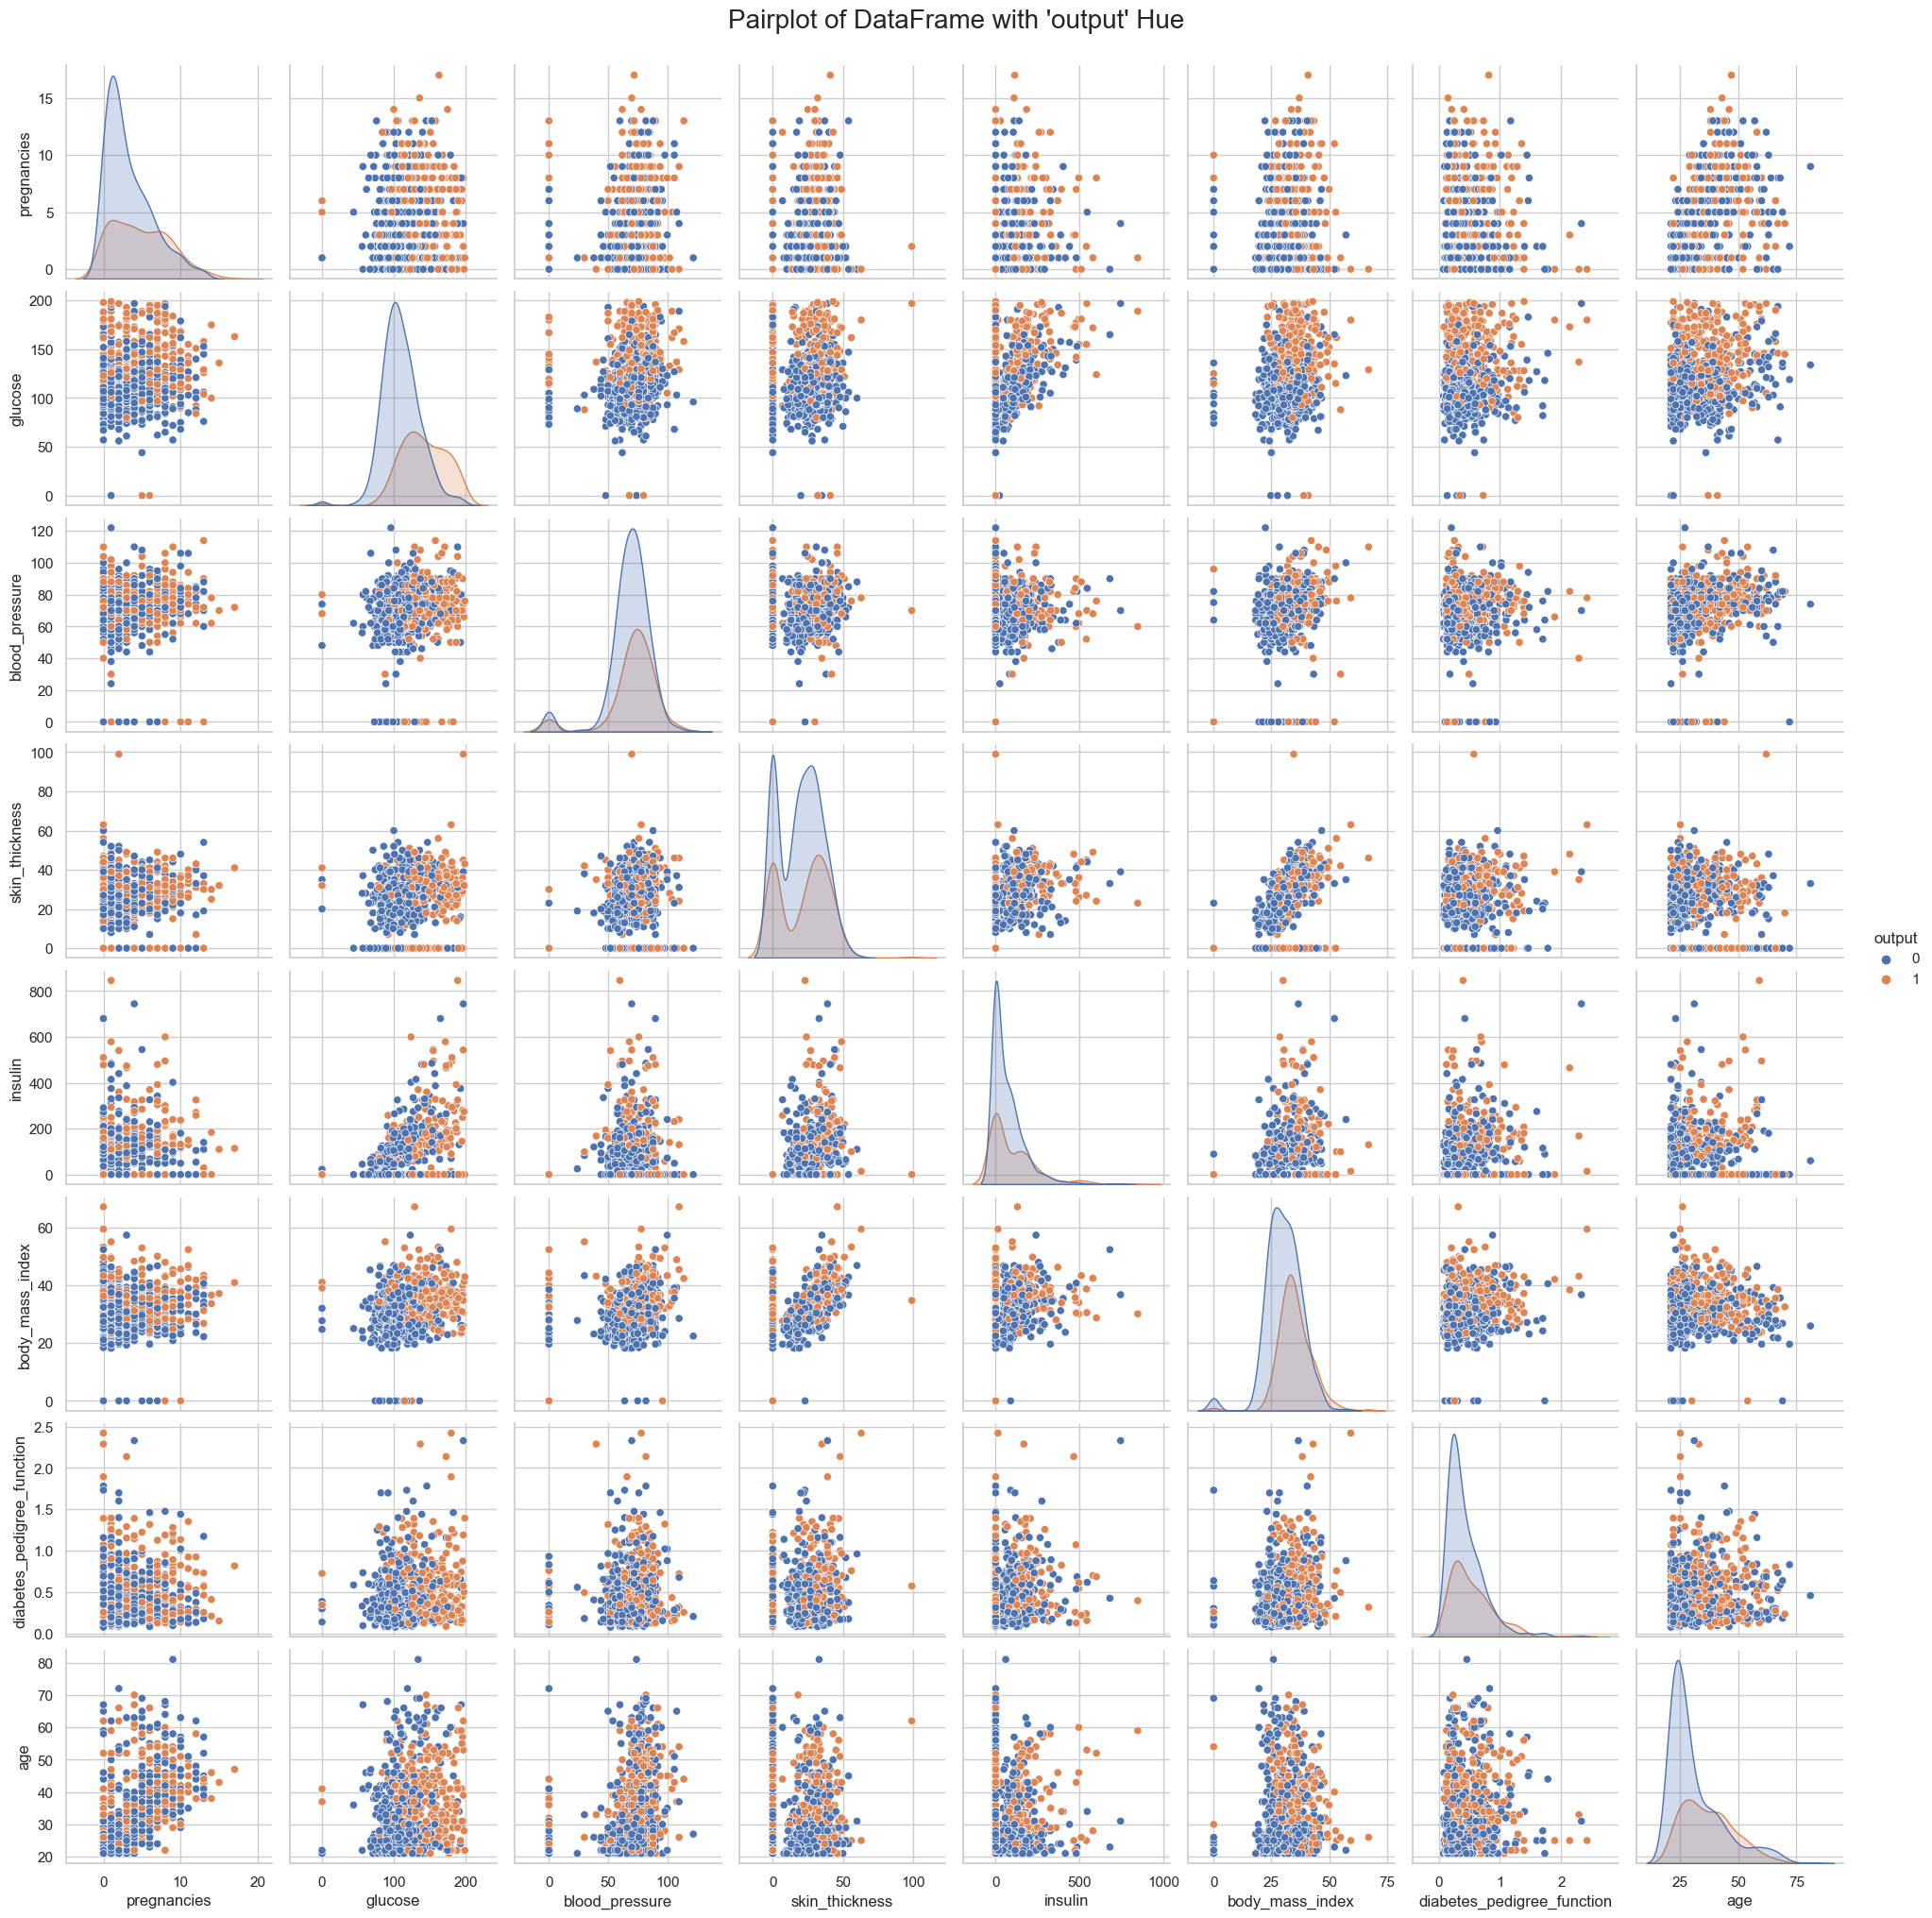

In [14]:
warnings.filterwarnings("ignore")

plt.figure()
g = sns.pairplot(df, hue='output')
title = g.fig.suptitle("Pairplot of DataFrame with 'output' Hue", fontsize=20, y=1.02)
plt.subplots_adjust(top=0.99) 
plt.show()

**PAIRPLOT INTERPRETATION:**
- From most of the **scatterplots** it becomes apparent that there is a lack of distinct separation between data points representing individuals with and without diabetes. In these plots, the orange and blue points tend to overlap.
- **Density plots** offer a visual and intuitive method for evaluating the connection between individual features and the binary classification task. When these plots reveal a notable distinction in the feature distributions between the two classes, it suggests that the feature could be informative and potentially serve as a strong predictor. Conversely, if the feature distributions overlap heavily, it may suggest that the feature is less discriminative. In this particular case, when there is overlap between the orange and blue curves, it indicates that the feature does not effectively distinguish between the outcomes. More precisely, it is evident that, for instance, in the case of glucose and body mass index, these two features exhibit greater differentiation between the curves compared to the blood pressure variable. This suggests that glucose and body mass index are likely to provide more informative insights into determining whether an individual has diabetes or not.

## Data Preprocessing

#### check for missing and duplicate values

In [15]:
# check the missing values
df.isnull().sum()

pregnancies                   0
glucose                       0
blood_pressure                0
skin_thickness                0
insulin                       0
body_mass_index               0
diabetes_pedigree_function    0
age                           0
output                        0
dtype: int64

There are no missing values.

In [16]:
#check the duplicated value
df.duplicated().sum()

0

There are no duplicates, therefore it is possible to procede with the analysis.

#### impute ZERO values

In [17]:
features = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'body_mass_index']

# count the number of rows with 0 value
for feature in features:
    count_zeros = (df[feature] == 0).sum()
    print(f"Number of rows with 0 in {feature}: {count_zeros}")


Number of rows with 0 in glucose: 5
Number of rows with 0 in blood_pressure: 35
Number of rows with 0 in skin_thickness: 227
Number of rows with 0 in insulin: 373
Number of rows with 0 in body_mass_index: 11


Imputation methodology:
- remove glucose and body_mass_index rows with a 0 value since are very few
- impute all the other variables with the median value

In [18]:
# Removing rows where 'glucose' or 'body_mass_index' have a value of 0
df= df[(df['glucose'] != 0) & (df['body_mass_index'] != 0)]

#### split train and test set

In [19]:
# create X and y
X = df.copy()
X.drop(['output'], axis = 1, inplace=True)

y = df['output']
y = pd.DataFrame(y)

In [20]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 

**stratify=y** ensures that the train and test splits have approximately the same percentage of samples for each class as present in the original dataset.

In [21]:
# occurrence of 0 and 1 values in y_train
count1 = y_train.value_counts()

print("number of rows with 0:", count1[0])
print("number of rows with 1:", count1[1])

number of rows with 0: 390
number of rows with 1: 210


In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(600, 8)
(151, 8)
(600, 1)
(151, 1)


#### Imputing

In [23]:
from sklearn.impute import SimpleImputer

# Selecting the columns to impute
columns_to_impute = ['blood_pressure', 'skin_thickness', 'insulin']

imputer = SimpleImputer(missing_values=0, strategy='mean')

# Applying the imputer 
X_train[columns_to_impute] = imputer.fit_transform(X_train[columns_to_impute])
X_test[columns_to_impute] = imputer.transform(X_test[columns_to_impute])

#### Scaling the features with RobustScaler

Robust Scaler has been chosen since is more resistant to outliers. This means that scales the data so that the median is zero and the interquartile range (IQR) is one. This helps mitigate the effect of outliers because the IQR is less influenced by extreme values compared to the standard deviation. It is a suitable metodology in the case analyzed since, as stated before, distribution with long tails or that contains extreme values are present in the dataset.

In [24]:
# Initialize the Robust Scaler
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Transform the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [25]:
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()

## Classification Models

The selection of models was guided by the requirement for high interpretability, which is essential in the context of medical diagnoses, as it allows healthcare professionals to understand and trust the decision-making process

Models chosen:
1. **Logistic regression**
2. **KNN**
3. **Decision Tree Classifier**

### 1) LOGISTIC REGRESSION

In [26]:
X_train_scaled2 = sm.add_constant(X_train_scaled)
X_test_scaled2 = sm.add_constant(X_test_scaled)

# Create the Logistic Regression model 
log_reg = sm.Logit(y_train, X_train_scaled2)

# Train the model with the training data
result = log_reg.fit()

print(result.summary())

# Make predictions on the training data
y_pred_train_log = result.predict(X_train_scaled2)
y_pred_train_log = (y_pred_train_log > 0.5).astype(int) # 0.5 is the threshold that minimizes the errors 

# Calculate performance metrics for the training data
accuracy_train_log = accuracy_score(y_train, y_pred_train_log)
precision_train_log = precision_score(y_train, y_pred_train_log)
recall_train_log = recall_score(y_train, y_pred_train_log)
f1_train_log = f1_score(y_train, y_pred_train_log)

# Make predictions on the test data
y_pred_test_log = result.predict(X_test_scaled2)
y_pred_test_log = (y_pred_test_log > 0.5).astype(int)  

# Calculate performance metrics for the test data
accuracy_test_log = accuracy_score(y_test, y_pred_test_log)
precision_test_log = precision_score(y_test, y_pred_test_log)
recall_test_log = recall_score(y_test, y_pred_test_log)
f1_test_log = f1_score(y_test, y_pred_test_log)

# Print the performance metrics
print("\nTraining Set:")
print("Accuracy:", accuracy_train_log)
print("Precision:", precision_train_log)
print("Recall:", recall_train_log)
print("F1-Score:", f1_train_log)
print("\nTest Set:")
print("Accuracy:", accuracy_test_log)
print("Precision:", precision_test_log)
print("Recall:", recall_test_log)
print("F1-Score:", f1_test_log)

Optimization terminated successfully.
         Current function value: 0.478197
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  600
Model:                          Logit   Df Residuals:                      591
Method:                           MLE   Df Model:                            8
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                  0.2614
Time:                        19:24:21   Log-Likelihood:                -286.92
converged:                       True   LL-Null:                       -388.47
Covariance Type:            nonrobust   LLR p-value:                 1.420e-39
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.2014      0.129     -9.327      0.000      

In [27]:
# Calculate deviance for the training set
null_model = sm.Logit(y_train, sm.add_constant(np.ones_like(y_train)))
null_result = null_model.fit(disp=False)
deviance_null = -2 * null_result.llf 
# Calculate deviance for the training set
deviance_train_log = -2 * result.llf
# Calculate deviance for the test set
deviance_test_log = -2 * result.llf

# Print the deviance
print("Deviance (Null Model):", deviance_null)
print("\nTraining Set:")
print("Deviance:", deviance_train_log)
print("\nTest Set:")
print("Deviance:", deviance_test_log)

Deviance (Null Model): 776.9359668415591

Training Set:
Deviance: 573.83633104359

Test Set:
Deviance: 573.83633104359


**RESULTS INTERPRETATION**:

The variables that are **statistically significant** in predicting the outcome are:

- **pregnancies**: For each additional pregnancy, the log-odds of a woman having diabetes increase by 0.6549.
- **glucose**: If a person has a higher plasma glucose concentration, the log-odds of them having diabetes increase by 1.5080.
- **body_mass_index**: If a person has a higher body mass index, the log-odds of them having diabetes increase by 0.8380.
- **diabetes_pedigree_function**: If a person has a higher diabetes pedigree function value, the log-odds of them having diabetes increase by 0.2520. 

Therefore, this indicates that having higher values in these features is associated with an increased likelihood of having diabetes according to the logistic regression model.



**Performance metrics**:

- **Deviance**: the null model, in this case, is a baseline model that assumes no relationship between the predictors and the response variable. In general, a lower deviance indicates a model that fits the data better. Here, it can be observed that the deviance decreases  compared to the null model.
- **Accuracy**: is the ratio of correctly predicted instances to the total number of instances in the dataset. An accuracy of 0.8013245033112583 means that the model correctly predicted the outcome for approximately 80.13% of the test samples, but accuracy alone can be misleading in imbalanced datasets.
- **Precision**: is the ratio of correctly predicted positive observations to the total predicted positives. A precision of 0.7948717948717948 means that when the model predicts an observation as positive, it is correct only about 79.49% of the time. This indicates the presence of false positives.
- **Recall**: This is the ratio of correctly predicted positive observations to all the observations in the actual class. A recall of 0.5849056603773585 means that the model correctly identifies about 58.50% of the actual positive cases.
- **F1 Score**: This is the weighted average of precision and recall. It takes both false positives and false negatives into account. A high F1-score suggests better robustness and reliability in terms of both precision and recall. F1-Score closer to 0 indicates poor predictive power. Here the F1-score of 0.6739130434782609 is still quite low, suggesting that the balance between precision and recall is not ideal.

--> In terms of **which metrics to concentrate the most**, in this situation both recall and precision are important. Precision since refers to the cases that the model wrongly classified as having diabetes when they actually do not, therefore a needless treatment could result. On the other hand recall refers to the cases that the model wrongly classified as not having diabetes when they actually do. Here missing a positive has much bigger cost than wrongly classifying someone as positive. If we miss a person with diabete he will not start curing itself and the consequences on his health could be worst.
Therefore the focus will be both on F1 and recall, but with higher notice on recall.

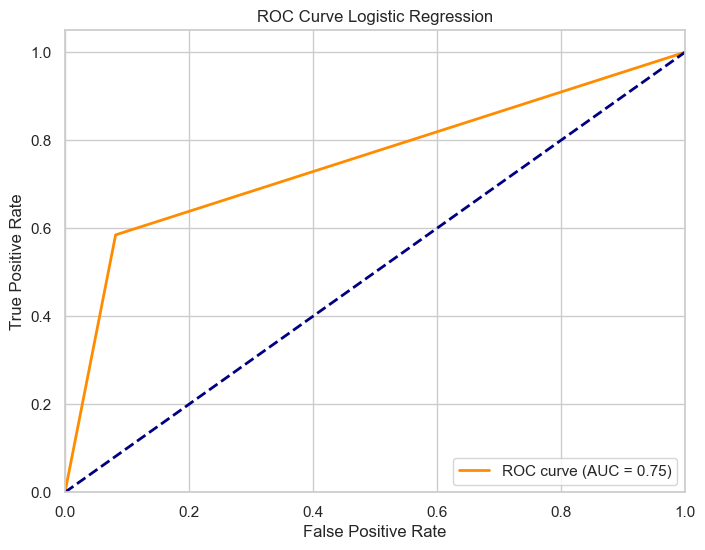

In [28]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_log)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test_log)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc='lower right')
plt.show()


The ROC curve with an AUC of 0.75 shows moderate predictive ability, revealing a trade-off between sensitivity and specificity. The analysis of the plot underscores the need to carefully consider the threshold settings to optimize true positive rates while minimizing false positives. 

--> Hence, additional models with the capability to identify non-linear patterns will be developed to achieve improved outcomes.

In [29]:
df_performance = pd.DataFrame(columns = ["Model", 'Accuracy', 'Precision', "Recall", "F1 Score"])

In [30]:
df_performance.loc[0] = ["logistic", accuracy_test_log, precision_test_log, recall_test_log, f1_test_log]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913


### 2) KNN

#### Choose the right K

In [31]:
f1_scores = []
recall_scores = []

for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    
    f1 = f1_score(y_test, pred_i)  
    recall = recall_score(y_test, pred_i)  
    
    f1_scores.append(f1)
    recall_scores.append(recall)

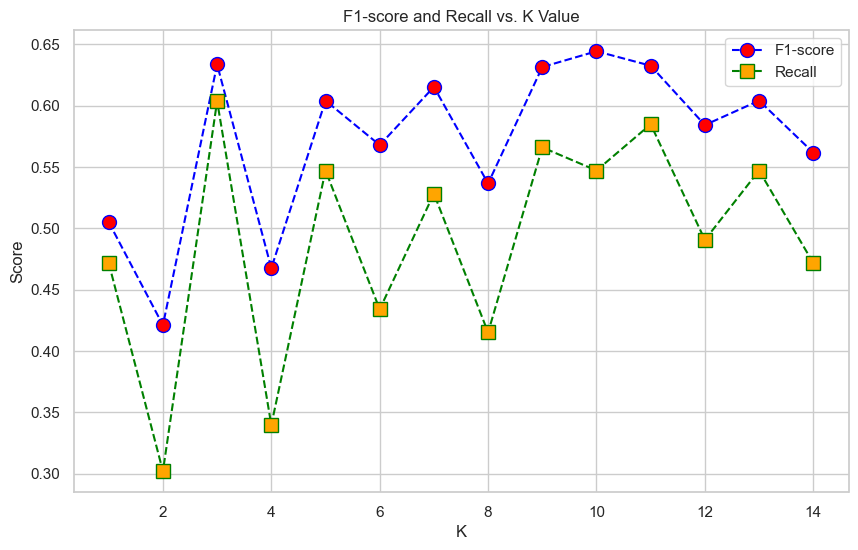

In [32]:
plt.figure(figsize=(10, 6))

# Plot F1-score
plt.plot(range(1, 15), f1_scores, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='F1-score')

# Plot Recall
plt.plot(range(1, 15), recall_scores, color='green', linestyle='dashed', marker='s',
         markerfacecolor='orange', markersize=10, label='Recall')

plt.title('F1-score and Recall vs. K Value')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


Here we can see that K=3 gives the best results in terms of both metrics. Therefore the model will be train with K= 3.

In [33]:
# Create the K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=3)  

# Train the model with the training data
knn.fit(X_train_scaled, y_train)

# Make predictions on the training data
y_pred_train_knn = knn.predict(X_train_scaled)

# Calculate performance metrics for the training data
accuracy_train_knn = accuracy_score(y_train, y_pred_train_knn)
precision_train_knn = precision_score(y_train, y_pred_train_knn)
recall_train_knn = recall_score(y_train, y_pred_train_knn)
f1_train_knn = f1_score(y_train, y_pred_train_knn)

# Make predictions on the test data
y_pred_test_knn = knn.predict(X_test_scaled)

# Calculate performance metrics for the test data
accuracy_test_knn = accuracy_score(y_test, y_pred_test_knn)
precision_test_knn = precision_score(y_test, y_pred_test_knn)
recall_test_knn = recall_score(y_test, y_pred_test_knn)
f1_test_knn = f1_score(y_test, y_pred_test_knn)

# Print the performance metrics
print("Training Set:")
print("Accuracy:", accuracy_train_knn)
print("Precision:", precision_train_knn)
print("Recall:", recall_train_knn)
print("F1-Score:", f1_train_knn)
print("\nTest Set:")
print("Accuracy:", accuracy_test_knn)
print("Precision:", precision_test_knn)
print("Recall:", recall_test_knn)
print("F1-Score:", f1_test_knn)

Training Set:
Accuracy: 0.825
Precision: 0.766497461928934
Recall: 0.719047619047619
F1-Score: 0.7420147420147419

Test Set:
Accuracy: 0.7549668874172185
Precision: 0.6666666666666666
Recall: 0.6037735849056604
F1-Score: 0.6336633663366337


In [34]:
print(classification_report(y_test,y_pred_test_knn))
print(confusion_matrix(y_test,y_pred_test_knn))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        98
           1       0.67      0.60      0.63        53

    accuracy                           0.75       151
   macro avg       0.73      0.72      0.72       151
weighted avg       0.75      0.75      0.75       151

[[82 16]
 [21 32]]


Owing to the dataset's imbalance, is it possible to observe a significant contrast in metrics accuracy when forecasting individuals without diabetes, who constitute the majority class, versus those with diabetes. 

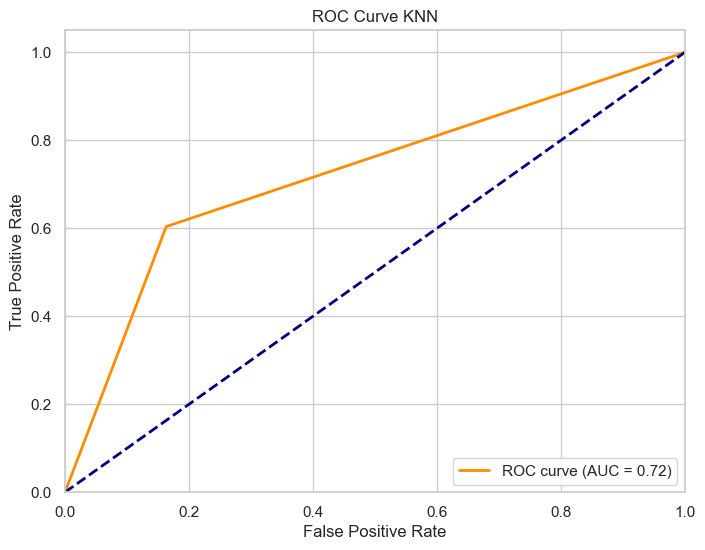

In [35]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_knn)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test_knn)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc='lower right')
plt.show()

In [36]:
df_performance.loc[1] = ["KNN", accuracy_test_knn, precision_test_knn, recall_test_knn, f1_test_knn]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663


From these first two models it is possible to notice that KNN performs better in terms of Recall, however logistic regression performs better overall.

### 3) CLASSIFICATION TREE

In [37]:
# Create the Decision Tree model 
decision_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Train the model with the training data
decision_tree.fit(X_train_scaled, y_train)

# Make predictions on the training data
y_pred_train_dt = decision_tree.predict(X_train_scaled)

# Calculate performance metrics for the training data
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
precision_train_dt = precision_score(y_train, y_pred_train_dt)
recall_train_dt = recall_score(y_train, y_pred_train_dt)
f1_train_dt = f1_score(y_train, y_pred_train_dt)

# Make predictions on the test data
y_pred_test_dt = decision_tree.predict(X_test_scaled)

# Calculate performance metrics for the test data
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)
precision_test_dt = precision_score(y_test, y_pred_test_dt)
recall_test_dt = recall_score(y_test, y_pred_test_dt)
f1_test_dt = f1_score(y_test, y_pred_test_dt)

# Print the performance metrics
print("Decision Tree Model")
print("Training Set:")
print("Accuracy:", accuracy_train_dt)
print("Precision:", precision_train_dt)
print("Recall:", recall_train_dt)
print("F1-Score:", f1_train_dt)
print("\nTest Set:")
print("Accuracy:", accuracy_test_dt)
print("Precision:", precision_test_dt)
print("Recall:", recall_test_dt)
print("F1-Score:", f1_test_dt)

Decision Tree Model
Training Set:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0

Test Set:
Accuracy: 0.7218543046357616
Precision: 0.6222222222222222
Recall: 0.5283018867924528
F1-Score: 0.5714285714285715


In [38]:
cm=confusion_matrix(y_test,y_pred_test_dt)
print(cm)
print(classification_report(y_test,y_pred_test_dt))

[[81 17]
 [25 28]]
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        98
           1       0.62      0.53      0.57        53

    accuracy                           0.72       151
   macro avg       0.69      0.68      0.68       151
weighted avg       0.71      0.72      0.72       151



The main reason for this discrepancy in the resuts between training and test set is overfitting. The model has become too complex and has essentially "memorized" the training data rather than learning the underlying patterns. This is possibly due to the fact that the decision tree has likely grown too deep and developed branches that cater to individual data points or noise, and therefore when applied to the test set, where it encounters different patterns or variability, its performance drops. Therefore hyperparameter tuning has been implemented through **GridSearchCV** to find the best hyperparameters and to reduce overfitting. 

In [39]:
# Create the Decision Tree model 
decision_tree_gs = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Define the parameters for GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 7], # small numbers chosen to limit overfitting
}

# Define the scoring metric (recall)
scoring_metric = make_scorer(recall_score)

# Create the GridSearchCV object with recall as the scoring metric
grid_search_dt = GridSearchCV(
    decision_tree_gs, param_grid_dt, cv=3, n_jobs=-1, scoring=scoring_metric, refit=True
)

# Perform the grid search
grid_search_dt.fit(X_train_scaled, y_train)

# Get the results
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

# Create the Decision Tree model with the best parameters found
best_decision_tree = DecisionTreeClassifier(**best_params_dt, random_state=42, class_weight='balanced')

# Train the model with the training data
best_decision_tree.fit(X_train_scaled, y_train)

# Make predictions on the training data
y_pred_train_dt_gs = best_decision_tree.predict(X_train_scaled)

# Calculate performance metrics for train data
accuracy_train_dt_gs = accuracy_score(y_train, y_pred_train_dt_gs)
precision_train_dt_gs = precision_score(y_train, y_pred_train_dt_gs)
recall_train_dt_gs = recall_score(y_train, y_pred_train_dt_gs)
f1_train_dt_gs = f1_score(y_train, y_pred_train_dt_gs)

# Make predictions on the test data
y_pred_test_dt_gs = best_decision_tree.predict(X_test_scaled)

# Calculate performance metrics for test data
accuracy_test_dt_gs = accuracy_score(y_test, y_pred_test_dt_gs)
precision_test_dt_gs = precision_score(y_test, y_pred_test_dt_gs)
recall_test_dt_gs = recall_score(y_test, y_pred_test_dt_gs)
f1_test_dt_gs = f1_score(y_test, y_pred_test_dt_gs)

# Print the performance metrics
print("Decision Tree Model")
print("Training Set:")
print("Accuracy:", accuracy_train_dt_gs)
print("Precision:", precision_train_dt_gs)
print("Recall:", recall_train_dt_gs)
print("F1-Score:", f1_train_dt_gs)
print("\nTest Set:")
print("Accuracy:", accuracy_test_dt_gs)
print("Precision:", precision_test_dt_gs)
print("Recall:", recall_test_dt_gs)
print("F1-Score:", f1_test_dt_gs)

Decision Tree Model
Training Set:
Accuracy: 0.7466666666666667
Precision: 0.5911949685534591
Recall: 0.8952380952380953
F1-Score: 0.712121212121212

Test Set:
Accuracy: 0.7019867549668874
Precision: 0.5571428571428572
Recall: 0.7358490566037735
F1-Score: 0.6341463414634148


In [40]:
df_performance.loc[2] = ["CART GridSearchCV", accuracy_test_dt_gs, precision_test_dt_gs, recall_test_dt_gs, f1_test_dt_gs]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146


In [41]:
best_params_dt

{'criterion': 'gini', 'max_depth': 3}

As it is possible to see the model performs way better with the GridSearch, without overfitting. From the GridSearch is it possible to see that the 'gini' criterion has been chosen. Moreover, the max_depth has been chosen to 3 instead of the default none value that can lead very easily to overfitting (as seen in the earlier results, where the model fitted perfectly the training data).

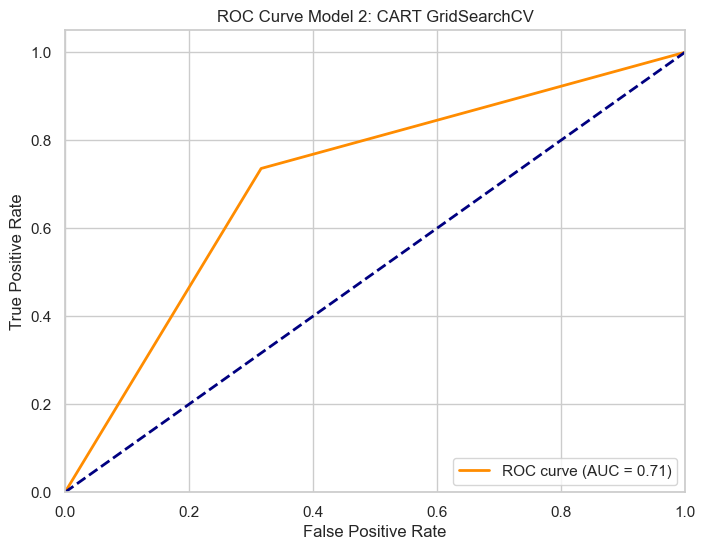

In [42]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_dt_gs)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test_dt_gs)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 2: CART GridSearchCV')
plt.legend(loc='lower right')
plt.show()

Model 2 has been chosen to be the best one overall considering Recall

## Try to increase the performance of the best model: classification tree

Since the dataset at hand is unbalanced some useful techniques has been applied.


### Undersampling

This technique involves reducing the number of instances from the majority class to balance the class distribution. 

In [43]:
# Create the undersampler object 
undersampler = RandomUnderSampler(random_state=42)

# Apply the undersampler to the training data
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_scaled, y_train)

X_train_undersampled = pd.DataFrame(X_train_undersampled, columns=X_train_scaled.columns)
y_train_undersampled = pd.DataFrame(y_train_undersampled, columns=['output'])  

In [44]:
# verify the distribution after undersampling
unique, counts = np.unique(y_train_undersampled, return_counts=True)
print(dict(zip(unique, counts)))

{0: 210, 1: 210}


#### Model 3: CART Undersampling

In [45]:
# CLASSIFICATION TREE

# Create the Decision Tree model with the specified parameters
decision_tree_model3 = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=3, 
    random_state=42, 
)


# Train the model with the training data
decision_tree_model3.fit(X_train_undersampled, y_train_undersampled)

# Make predictions on the training data
y_pred_train3 = decision_tree_model3.predict(X_train_undersampled)

# Calculate performance metrics for training
accuracy_train_dt_3 = accuracy_score(y_train_undersampled, y_pred_train3)
precision_train_dt_3 = precision_score(y_train_undersampled, y_pred_train3)
recall_train_dt_3 = recall_score(y_train_undersampled, y_pred_train3)
f1_train_dt_3 = f1_score(y_train_undersampled, y_pred_train3)

# Make predictions on the test data
y_pred_test3 = decision_tree_model3.predict(X_test_scaled)

# Calculate performance metrics for testing
accuracy_test_dt_3 = accuracy_score(y_test, y_pred_test3)
precision_test_dt_3 = precision_score(y_test, y_pred_test3)
recall_test_dt_3 = recall_score(y_test, y_pred_test3)
f1_test_dt_3 = f1_score(y_test, y_pred_test3)

# Print the performance metrics
print("Decision Tree Model")
print("Training Set:")
print("Accuracy:", accuracy_train_dt_3)
print("Precision:", precision_train_dt_3)
print("Recall:", recall_train_dt_3)
print("F1-Score:", f1_train_dt_3)
print("\nTest Set:")
print("Accuracy:", accuracy_test_dt_3)
print("Precision:", precision_test_dt_3)
print("Recall:", recall_test_dt_3)
print("F1-Score:", f1_test_dt_3)

Decision Tree Model
Training Set:
Accuracy: 0.7476190476190476
Precision: 0.6830985915492958
Recall: 0.9238095238095239
F1-Score: 0.7854251012145749

Test Set:
Accuracy: 0.695364238410596
Precision: 0.5421686746987951
Recall: 0.8490566037735849
F1-Score: 0.6617647058823528


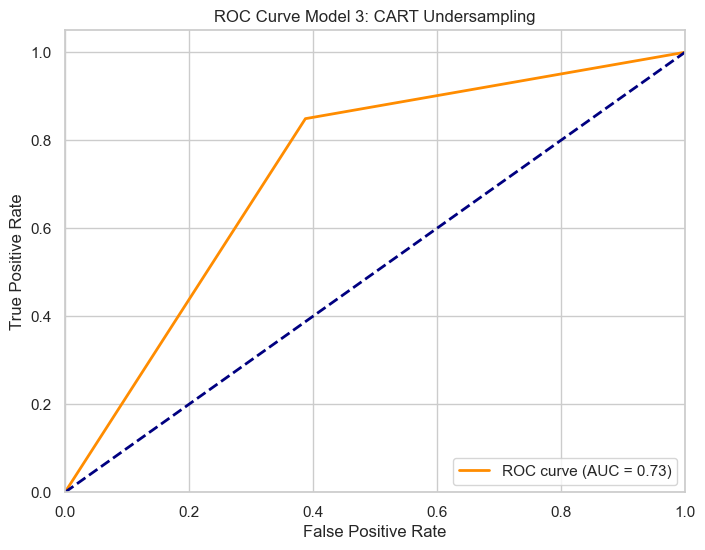

In [46]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test3)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test3)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 3: CART Undersampling')
plt.legend(loc='lower right')
plt.show()

In [47]:
df_performance.loc[3] = ["CART Undersampling", accuracy_test_dt_3, precision_test_dt_3, recall_test_dt_3, f1_test_dt_3]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765


#### Try to adjust the decision Threshold to increase the recall

When the model gives us a result, it gives us a probability of a case being positive. Therefore we must establish a THRESHOLD to treat this probability as either positive or negative classification.

So the setting of this threshold depend on if the desire is to have a more sensitive or specific model.
- 50% cut-off minimizes the errors
- 25% cut-off (+FP) the model is more sensitive (more attention on RECALL)
- 75% cut-off (+FN) the model is more specific 

#### Model 4: CART Undersampling threshold for max recall

In [48]:
# Get predicted probabilities for the positive class
y_scores_train = decision_tree_model3.predict_proba(X_train_undersampled)[:, 1] 
y_scores_test = decision_tree_model3.predict_proba(X_test_scaled)[:, 1]

# Choose a new threshold
new_threshold = 0.25 

# Apply the new threshold to get the new predictions
y_pred_train_new_threshold = (y_scores_train > new_threshold).astype(int)
y_pred_test_new_threshold = (y_scores_test > new_threshold).astype(int)

# Calculate performance metrics with the new threshold
accuracy_train_new_threshold = accuracy_score(y_train_undersampled, y_pred_train_new_threshold)
precision_train_new_threshold = precision_score(y_train_undersampled, y_pred_train_new_threshold)
recall_train_new_threshold = recall_score(y_train_undersampled, y_pred_train_new_threshold)
f1_train_new_threshold = f1_score(y_train_undersampled, y_pred_train_new_threshold)

accuracy_test_new_threshold = accuracy_score(y_test, y_pred_test_new_threshold)
precision_test_new_threshold = precision_score(y_test, y_pred_test_new_threshold)
recall_test_new_threshold = recall_score(y_test, y_pred_test_new_threshold)
f1_test_new_threshold = f1_score(y_test, y_pred_test_new_threshold)

# Print the performance metrics with the new threshold
print("Decision Tree Model with New Threshold")
print("Training Set:")
print("Accuracy:", accuracy_train_new_threshold)
print("Precision:", precision_train_new_threshold)
print("Recall:", recall_train_new_threshold)
print("F1-Score:", f1_train_new_threshold)
print("\nTest Set:")
print("Accuracy:", accuracy_test_new_threshold)
print("Precision:", precision_test_new_threshold)
print("Recall:", recall_test_new_threshold)
print("F1-Score:", f1_test_new_threshold)


Decision Tree Model with New Threshold
Training Set:
Accuracy: 0.7261904761904762
Precision: 0.6507936507936508
Recall: 0.9761904761904762
F1-Score: 0.7809523809523808

Test Set:
Accuracy: 0.6357615894039735
Precision: 0.49
Recall: 0.9245283018867925
F1-Score: 0.6405228758169934


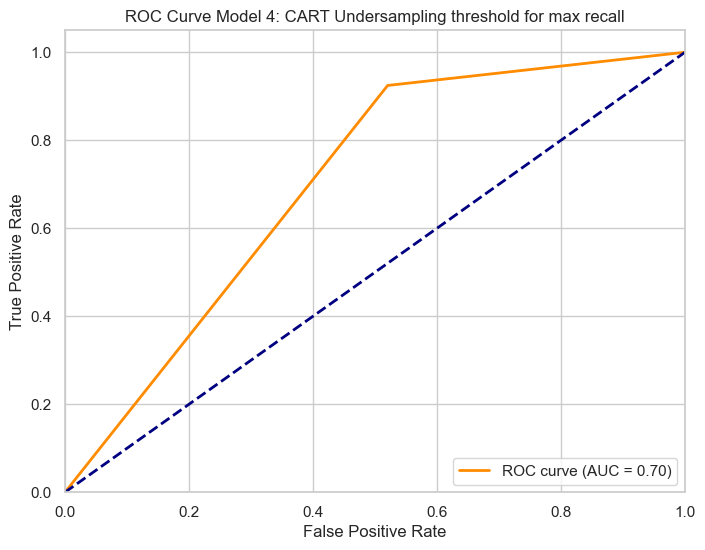

In [49]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_new_threshold)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test_new_threshold)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 4: CART Undersampling threshold for max recall')
plt.legend(loc='lower right')
plt.show()

The outcomes indicate that while with the adjusted threshold the model has been able to catch almost every true positive, it has come at the cost of a big reduction in precision.

By setting the threshold at 25%, the model attained an impressively high recall, accurately detecting approximately 92% of true positive cases. However, this improvement in recall has led to a huge reduction in all the other metrics. Even if this optimization has been used in another research (Yang et al., 2021), from my limited expertise in the subject, it appears that while the model successfully minimizes false negatives, the trade-off in other performance metrics seems quite substantial. This is concerning because, although missing a positive case is risky, incorrectly diagnosing someone with diabetes when they are healthy also carries significant risks, and that is also why other studies focuses more on optimizing the trade-off between precision and recall (Lu et al., 2020 and Assiri et al., 2020). 
Nevertheless, in different contexts such as cancer diagnosis, these results could be justified (Macios and Nowakowski, 2022). In such scenarios, retaining the model could be considered acceptable despite its potential to necessitate additional tests and associated costs for healthcare facilities, as it minimizes the risk of potentially fatal oversights.

In [50]:
df_performance.loc[4] = ["CART Undersampling threshold for Max recall", accuracy_test_new_threshold, precision_test_new_threshold, 
                         recall_test_new_threshold, f1_test_new_threshold]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523


##### find the threshold that maximize both Recall and F1

In [51]:
def find_optimal_threshold(decision_tree_model, X_test, y_test):
    best_threshold = 0.25
    min_difference = float('inf')  

    for threshold in range(25, 50):  # Iterate from 25% to 49% 
        new_threshold = threshold / 100
        y_scores_test = decision_tree_model.predict_proba(X_test)[:, 1]
        y_pred_test = (y_scores_test > new_threshold).astype(int)

        recall = recall_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test)
        difference = abs(recall - f1)  

        # Update the best threshold if the current difference is smaller
        if difference < min_difference:
            min_difference = difference
            best_threshold = new_threshold

    return best_threshold

best_threshold = find_optimal_threshold(decision_tree_model3, X_test_scaled, y_test)
print(f"Best Threshold: {best_threshold}")

Best Threshold: 0.36


#### Model 5: CART Undersampling best threshold

In [52]:
# Choose a new threshold
new_threshold1 = 0.36 

# Apply the new threshold to get the new predictions
y_pred_train_new_threshold1 = (y_scores_train > new_threshold1).astype(int)
y_pred_test_new_threshold1 = (y_scores_test > new_threshold1).astype(int)

# Calculate performance metrics with the new threshold
accuracy_train_new_threshold1 = accuracy_score(y_train_undersampled, y_pred_train_new_threshold1)
precision_train_new_threshold1 = precision_score(y_train_undersampled, y_pred_train_new_threshold1)
recall_train_new_threshold1 = recall_score(y_train_undersampled, y_pred_train_new_threshold1)
f1_train_new_threshold1 = f1_score(y_train_undersampled, y_pred_train_new_threshold1)

accuracy_test_new_threshold1 = accuracy_score(y_test, y_pred_test_new_threshold1)
precision_test_new_threshold1 = precision_score(y_test, y_pred_test_new_threshold1)
recall_test_new_threshold1 = recall_score(y_test, y_pred_test_new_threshold1)
f1_test_new_threshold1 = f1_score(y_test, y_pred_test_new_threshold1)

# Print the performance metrics with the new threshold
print("Decision Tree Model with New Threshold")
print("Training Set:")
print("Accuracy:", accuracy_train_new_threshold1)
print("Precision:", precision_train_new_threshold1)
print("Recall:", recall_train_new_threshold1)
print("F1-Score:", f1_train_new_threshold1)
print("\nTest Set:")
print("Accuracy:", accuracy_test_new_threshold1)
print("Precision:", precision_test_new_threshold1)
print("Recall:", recall_test_new_threshold1)
print("F1-Score:", f1_test_new_threshold1)

Decision Tree Model with New Threshold
Training Set:
Accuracy: 0.7476190476190476
Precision: 0.6830985915492958
Recall: 0.9238095238095239
F1-Score: 0.7854251012145749

Test Set:
Accuracy: 0.695364238410596
Precision: 0.5421686746987951
Recall: 0.8490566037735849
F1-Score: 0.6617647058823528


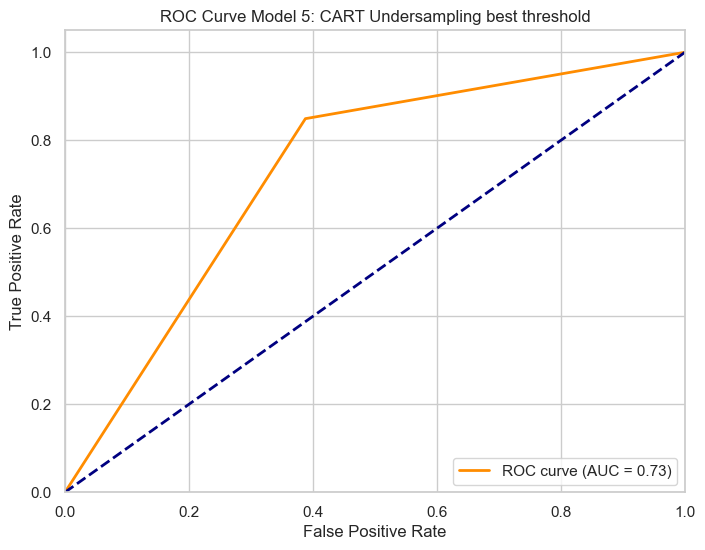

In [53]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_new_threshold1)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test_new_threshold1)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 5: CART Undersampling best threshold')
plt.legend(loc='lower right')
plt.show()

In [54]:
df_performance.loc[5] = ["CART Undersampling best threshold", accuracy_test_new_threshold1, precision_test_new_threshold1, 
                         recall_test_new_threshold1, f1_test_new_threshold1]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523
5,CART Undersampling best threshold,0.695364,0.542169,0.849057,0.661765


### Oversampling with SMOTE

The oversampling technique involves increasing the number of instances in the minority class by duplicating instances or generating synthetic instances. This technique can improve model performance on the minority class. However, this technique can lead to overfitting.

**SMOTE** 

Oversampling with SMOTE involves creating synthetic examples of the minority class in a dataset to achieve a balance between classes. SMOTE does this by selecting existing minority class instances and generating new instances that are similar, yet slightly different, by interpolating between them and other nearby examples. This technique helps to avoid overfitting that may occur with simple oversampling by simply duplicating minority class instances. 

In [55]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and transform the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Verify the class distribution after oversampling
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{0: 390, 1: 390}


#### Model 6: CART Oversampling

In [56]:
# CLASSIFICATION TREE

# Create the Decision Tree model with the specified parameters
decision_tree_model4 = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=3, 
    random_state=42, 
)


# Train the model with the training data
decision_tree_model4.fit(X_train_resampled, y_train_resampled)

# Make predictions on the training data
y_pred_train4 = decision_tree_model4.predict(X_train_resampled)

# Calculate performance metrics for train data
accuracy_train_dt_4 = accuracy_score(y_train_resampled, y_pred_train4)
precision_train_dt_4 = precision_score(y_train_resampled, y_pred_train4)
recall_train_dt_4 = recall_score(y_train_resampled, y_pred_train4)
f1_train_dt_4 = f1_score(y_train_resampled, y_pred_train4)

# Make predictions on the test data
y_pred_test4 = decision_tree_model4.predict(X_test_scaled)

# Calculate performance metrics for test data
accuracy_test_dt_4 = accuracy_score(y_test, y_pred_test4)
precision_test_dt_4 = precision_score(y_test, y_pred_test4)
recall_test_dt_4 = recall_score(y_test, y_pred_test4)
f1_test_dt_4 = f1_score(y_test, y_pred_test4)

# Print the performance metrics
print("Training Set:")
print("Accuracy:", accuracy_train_dt_4)
print("Precision:", precision_train_dt_4)
print("Recall:", recall_train_dt_4)
print("F1-Score:", f1_train_dt_4)
print("\nTest Set:")
print("Accuracy:", accuracy_test_dt_4)
print("Precision:", precision_test_dt_4)
print("Recall:", recall_test_dt_4)
print("F1-Score:", f1_test_dt_4)

Training Set:
Accuracy: 0.7512820512820513
Precision: 0.7425742574257426
Recall: 0.7692307692307693
F1-Score: 0.7556675062972291

Test Set:
Accuracy: 0.7748344370860927
Precision: 0.7021276595744681
Recall: 0.6226415094339622
F1-Score: 0.66


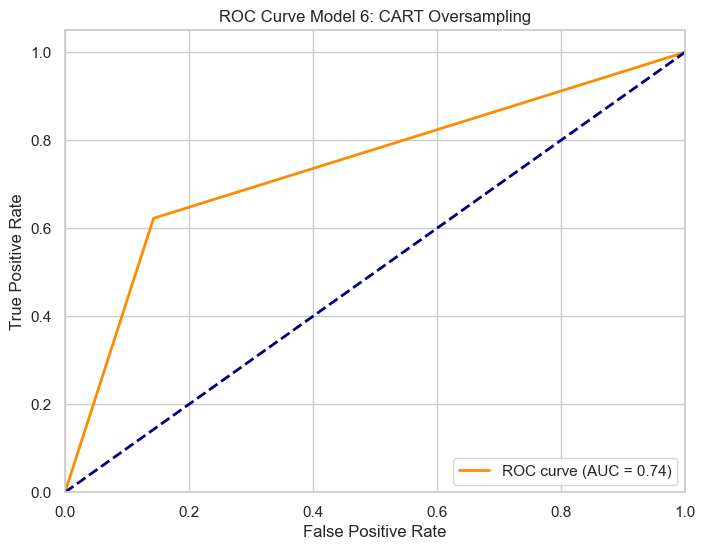

In [57]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test4)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test4)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 6: CART Oversampling')
plt.legend(loc='lower right')
plt.show()

In [58]:
df_performance.loc[6] = ["CART Oversampling", accuracy_test_dt_4, precision_test_dt_4, recall_test_dt_4, f1_test_dt_4]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523
5,CART Undersampling best threshold,0.695364,0.542169,0.849057,0.661765
6,CART Oversampling,0.774834,0.702128,0.622642,0.660000


#### Model 7: CART Oversampling best threshold

In [59]:
best_threshold = find_optimal_threshold(decision_tree_model4, X_test_scaled, y_test)
print(f"Best Threshold: {best_threshold}")

Best Threshold: 0.41


In [60]:
## best Threshold 

new_threshold2 = 0.41

# Get predicted probabilities for the positive class
y_scores_train2 = decision_tree_model4.predict_proba(X_train_resampled)[:, 1]  # Probabilities for the positive class
y_scores_test2 = decision_tree_model4.predict_proba(X_test_scaled)[:, 1]

# Apply the new threshold to get the new predictions
y_pred_train_new_threshold2 = (y_scores_train2 > new_threshold2).astype(int)
y_pred_test_new_threshold2 = (y_scores_test2 > new_threshold2).astype(int)

# Calculate performance metrics with the new threshold
accuracy_train_new_threshold2 = accuracy_score(y_train_resampled, y_pred_train_new_threshold2)
precision_train_new_threshold2 = precision_score(y_train_resampled, y_pred_train_new_threshold2)
recall_train_new_threshold2 = recall_score(y_train_resampled, y_pred_train_new_threshold2)
f1_train_new_threshold2 = f1_score(y_train_resampled, y_pred_train_new_threshold2)

accuracy_test_new_threshold2 = accuracy_score(y_test, y_pred_test_new_threshold2)
precision_test_new_threshold2 = precision_score(y_test, y_pred_test_new_threshold2)
recall_test_new_threshold2 = recall_score(y_test, y_pred_test_new_threshold2)
f1_test_new_threshold2 = f1_score(y_test, y_pred_test_new_threshold2)

# Print the performance metrics with the new threshold
print("Decision Tree Model with New Threshold")
print("Training Set:")
print("Accuracy:", accuracy_train_new_threshold2)
print("Precision:", precision_train_new_threshold2)
print("Recall:", recall_train_new_threshold2)
print("F1-Score:", f1_train_new_threshold2)
print("\nTest Set:")
print("Accuracy:", accuracy_test_new_threshold2)
print("Precision:", precision_test_new_threshold2)
print("Recall:", recall_test_new_threshold2)
print("F1-Score:", f1_test_new_threshold2)

Decision Tree Model with New Threshold
Training Set:
Accuracy: 0.7512820512820513
Precision: 0.7425742574257426
Recall: 0.7692307692307693
F1-Score: 0.7556675062972291

Test Set:
Accuracy: 0.7748344370860927
Precision: 0.7021276595744681
Recall: 0.6226415094339622
F1-Score: 0.66


In [61]:
df_performance.loc[7] = ["CART Oversampling best threshold",accuracy_test_new_threshold2, precision_test_new_threshold2, 
                         recall_test_new_threshold2, f1_test_new_threshold2]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523
5,CART Undersampling best threshold,0.695364,0.542169,0.849057,0.661765
6,CART Oversampling,0.774834,0.702128,0.622642,0.660000
7,CART Oversampling best threshold,0.774834,0.702128,0.622642,0.660000


The same decision tree classification model performs better with undersampling compared to oversampling with SMOTE (In terms of Recall) due to potential issues with oversampling. Oversampling can introduce noisy and redundant synthetic examples, leading to an increase in model complexity. Decision trees are sensitive to noise and may struggle with complex datasets. Undersampling retains important patterns and reduces noise, often resulting in improved model performance for imbalanced datasets.

### Combine Oversampling and Undersampling with SMOTEEN 

This balanced approach can help in creating a dataset that retains the important information from the majority class while also amplifying the signal from the minority class enough for the model to learn from it. The goal is to achieve a better balance between precision and recall, and between understanding the majority and minority classes. 
This model will:
-  Undersample the majority class to a level that still retains enough data for the model to learn the general patterns without being overwhelmed by the majority class.
- Oversample the minority class using SMOTE

In [62]:
smote_enn = SMOTEENN(random_state=42)

# Apply the combined sampler to the training data
X_train_combined_sampling, y_train_combined_sampling = smote_enn.fit_resample(X_train_scaled, y_train)

X_train_combined_sampling = pd.DataFrame(X_train_combined_sampling, columns=X_train_scaled.columns)
y_train_combined_sampling = pd.DataFrame(y_train_combined_sampling, columns=['output'])

# Verify the class distribution after combined sampling
unique_combined, counts_combined = np.unique(y_train_combined_sampling, return_counts=True)
print(dict(zip(unique_combined, counts_combined)))


{0: 176, 1: 242}


#### Model 8: CART SMOOTEN

In [63]:
# CLASSIFICATION TREE

# Create the Decision Tree model with the specified parameters
decision_tree_model5 = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=3, 
    random_state=42, 
)


# Train the model with the training data
decision_tree_model5.fit(X_train_combined_sampling, y_train_combined_sampling)

# Make predictions on the training data
y_pred_train5 = decision_tree_model5.predict(X_train_combined_sampling)

# Calculate performance metrics for train data
accuracy_train_dt_5 = accuracy_score(y_train_combined_sampling, y_pred_train5)
precision_train_dt_5 = precision_score(y_train_combined_sampling, y_pred_train5)
recall_train_dt_5 = recall_score(y_train_combined_sampling, y_pred_train5)
f1_train_dt_5 = f1_score(y_train_combined_sampling, y_pred_train5)

# Make predictions on the test data
y_pred_test5 = decision_tree_model5.predict(X_test_scaled)

# Calculate performance metrics for test data
accuracy_test_dt_5 = accuracy_score(y_test, y_pred_test5)
precision_test_dt_5 = precision_score(y_test, y_pred_test5)
recall_test_dt_5 = recall_score(y_test, y_pred_test5)
f1_test_dt_5 = f1_score(y_test, y_pred_test5)

# Print the performance metrics
print("Training Set:")
print("Accuracy:", accuracy_train_dt_5)
print("Precision:", precision_train_dt_5)
print("Recall:", recall_train_dt_5)
print("F1-Score:", f1_train_dt_5)
print("\nTest Set:")
print("Accuracy:", accuracy_test_dt_5)
print("Precision:", precision_test_dt_5)
print("Recall:", recall_test_dt_5)
print("F1-Score:", f1_test_dt_5)

Training Set:
Accuracy: 0.9401913875598086
Precision: 0.9539748953974896
Recall: 0.9421487603305785
F1-Score: 0.948024948024948

Test Set:
Accuracy: 0.7086092715231788
Precision: 0.5737704918032787
Recall: 0.660377358490566
F1-Score: 0.6140350877192982


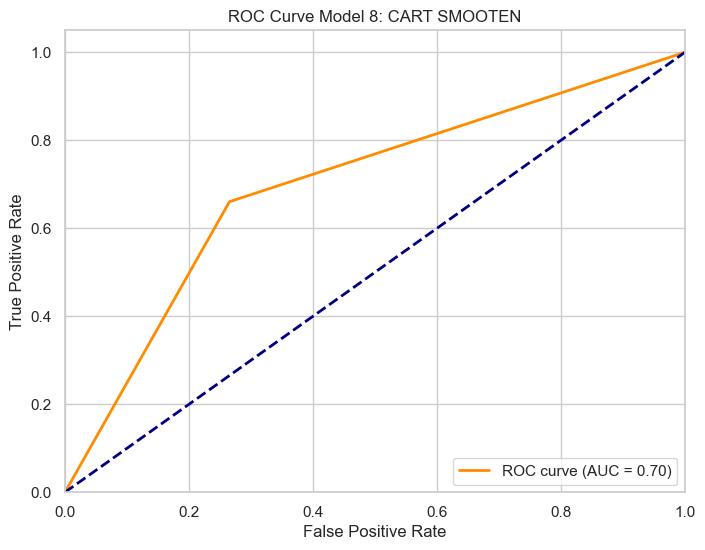

In [64]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test5)

# Calculate the AUC 
roc_auc = roc_auc_score(y_test, y_pred_test5)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 8: CART SMOOTEN')
plt.legend(loc='lower right')
plt.show()

In [65]:
df_performance.loc[8] = ["CART SMOOTEN", accuracy_test_dt_5, precision_test_dt_5, recall_test_dt_5, f1_test_dt_5]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523
5,CART Undersampling best threshold,0.695364,0.542169,0.849057,0.661765
6,CART Oversampling,0.774834,0.702128,0.622642,0.660000
7,CART Oversampling best threshold,0.774834,0.702128,0.622642,0.660000
8,CART SMOOTEN,0.708609,0.573770,0.660377,0.614035


#### Model 9: CART SMOOTEN best threshold

In [66]:
best_threshold = find_optimal_threshold(decision_tree_model5, X_test_scaled, y_test)
print(f"Best Threshold: {best_threshold}")

Best Threshold: 0.45


In [67]:
## best Threshold 

new_threshold3 = 0.45

# Get predicted probabilities for the positive class
y_scores_train3 = decision_tree_model5.predict_proba(X_train_resampled)[:, 1]  # Probabilities for the positive class
y_scores_test3 = decision_tree_model5.predict_proba(X_test_scaled)[:, 1]

# Apply the new threshold to get the new predictions
y_pred_train_new_threshold3 = (y_scores_train3 > new_threshold3).astype(int)
y_pred_test_new_threshold3 = (y_scores_test3 > new_threshold3).astype(int)

# Calculate performance metrics with the new threshold
accuracy_train_new_threshold3 = accuracy_score(y_train_resampled, y_pred_train_new_threshold3)
precision_train_new_threshold3 = precision_score(y_train_resampled, y_pred_train_new_threshold3)
recall_train_new_threshold3 = recall_score(y_train_resampled, y_pred_train_new_threshold3)
f1_train_new_threshold3 = f1_score(y_train_resampled, y_pred_train_new_threshold3)

accuracy_test_new_threshold3 = accuracy_score(y_test, y_pred_test_new_threshold3)
precision_test_new_threshold3 = precision_score(y_test, y_pred_test_new_threshold3)
recall_test_new_threshold3 = recall_score(y_test, y_pred_test_new_threshold3)
f1_test_new_threshold3 = f1_score(y_test, y_pred_test_new_threshold3)

# Print the performance metrics with the new threshold
print("Decision Tree Model with New Threshold")
print("Training Set:")
print("Accuracy:", accuracy_train_new_threshold3)
print("Precision:", precision_train_new_threshold3)
print("Recall:", recall_train_new_threshold3)
print("F1-Score:", f1_train_new_threshold3)
print("\nTest Set:")
print("Accuracy:", accuracy_test_new_threshold3)
print("Precision:", precision_test_new_threshold3)
print("Recall:", recall_test_new_threshold3)
print("F1-Score:", f1_test_new_threshold3)

Decision Tree Model with New Threshold
Training Set:
Accuracy: 0.7782051282051282
Precision: 0.737417943107221
Recall: 0.8641025641025641
F1-Score: 0.7957497048406139

Test Set:
Accuracy: 0.7086092715231788
Precision: 0.5737704918032787
Recall: 0.660377358490566
F1-Score: 0.6140350877192982


In [68]:
df_performance.loc[9] = ["CART SMOOTEN best threshold", accuracy_test_new_threshold3, precision_test_new_threshold3, 
                         recall_test_new_threshold3, f1_test_new_threshold3]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523
5,CART Undersampling best threshold,0.695364,0.542169,0.849057,0.661765
6,CART Oversampling,0.774834,0.702128,0.622642,0.660000
7,CART Oversampling best threshold,0.774834,0.702128,0.622642,0.660000
8,CART SMOOTEN,0.708609,0.573770,0.660377,0.614035
9,CART SMOOTEN best threshold,0.708609,0.573770,0.660377,0.614035


Considering these overall models used is it possible to notice that most of the CARTs, even with different data preprocessing technique applied, have the similar results. This is possible by considering that the characteristics the data might be such that the changes in sampling and thresholding do not significantly alter the model's performance. This can happen if the model is already performing near its potential given the data's inherent limitations. Moreover could be a limitation inherent inside the model. Decision Trees come with their own constraints, and adjusting sampling or threshold levels won't help much if these inherent limitations are the main reason for any performance issues.

By following the initial statement, that the best model is chosen considering Recall and F1, it is possible to say that model 3 is the best one.

## Final Insights

Here a tables is provided to easily see which are the the average and median values of the features of cases with diabete and not.

In [69]:
filter_condition1 = df['output'] == 1
filtered_df1 = df[filter_condition1].copy()

In [70]:
from IPython.display import display

# Select the variables of interest excluding 'glucose', 'body_mass_index', 'age', and 'output'
variables = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'body_mass_index', 'diabetes_pedigree_function', 'age']


# Calculate the mean and standard deviation for each variable separately
mean_values = filtered_df1[variables].mean()
std_values = filtered_df1[variables].std()
median_values = filtered_df1[variables].median()

# Create a summary DataFrame
summary_table = pd.DataFrame({'Mean': mean_values, 'Std': std_values, 'Median': median_values})
summary_table = summary_table.round(2)
summary_table.index = summary_table.index.astype(str)

display(summary_table)


,Mean,Std,Median
pregnancies,4.83,3.76,4.00
glucose,142.47,29.70,140.00
blood_pressure,70.97,21.18,74.00
skin_thickness,22.17,17.68,27.00
insulin,102.24,139.31,0.00
body_mass_index,35.38,6.64,34.30
diabetes_pedigree_function,0.55,0.37,0.45
age,36.97,10.98,36.00


In [71]:
filter_condition0 = df['output'] == 0
filtered_df0 = df[filter_condition0].copy()

In [72]:
# Calculate the mean and standard deviation for each variable separately
mean_values0 = filtered_df0[variables].mean()
std_values0 = filtered_df0[variables].std()
median_values0 = filtered_df0[variables].median()

# Create a summary DataFrame
summary_table0 = pd.DataFrame({'Mean': mean_values0, 'Std': std_values0, 'Median': median_values0})
summary_table0 = summary_table0.round(2)
summary_table0.index = summary_table0.index.astype(str)

display(summary_table0)

,Mean,Std,Median
pregnancies,3.32,3.03,2.00
glucose,110.83,24.84,107.50
blood_pressure,69.02,16.58,70.00
skin_thickness,19.90,14.87,21.00
insulin,70.25,99.55,43.50
body_mass_index,30.88,6.57,30.10
diabetes_pedigree_function,0.43,0.30,0.34
age,31.31,11.61,27.00


## Interpretation of the best model: Model 3 CART Undersampling

### Feature importance

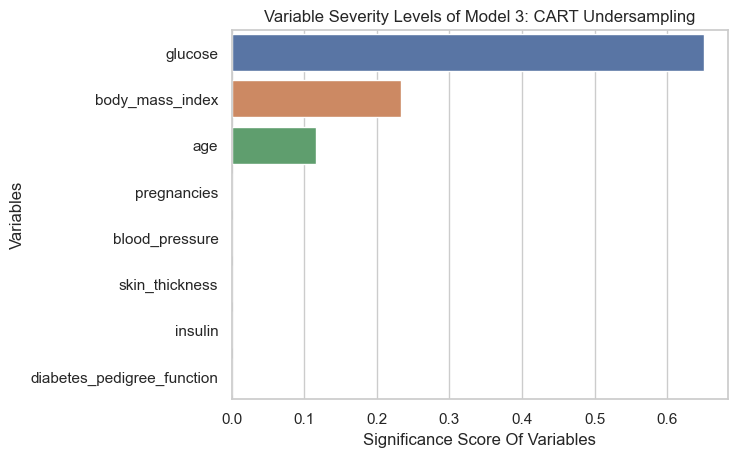

In [73]:
feature_imp = pd.Series(decision_tree_model3.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels of Model 3: CART Undersampling")
plt.show()

From the graph it is shown that the most important features in determining the presence or absence of diabete are glucose, body mass index and age. As a result, other features might indeed be contributing less to the recall, not because they lead to more false negatives by themselves, but because they add less predictive value when the goal is to minimize false negatives (i.e., maximize recall).

--> So comparing the Classification tree results and the Logistic regression results in terms of feature importance they agree in most of them.

Giving these results from the feature importance of the best model, and giving the Occam Razors principles, that says that the simplest explanation is usually the best one, the same model as model 3 has been trained with only glucose, body_mass_index and age to see if the performance would have changed.

In [74]:
selected_columns_undersampled = ['glucose', 'body_mass_index', 'age']
X_train_undersampled_features = X_train_undersampled[selected_columns_undersampled]
X_test_undersampled_features = X_test_scaled[selected_columns_undersampled]

#### Model 10: CART Undersampling with feature selection

In [75]:
# CLASSIFICATION TREE

# Create the Decision Tree model with the specified parameters
decision_tree_model_features = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=3, 
    random_state=42, 
)


# Train the model with the training data
decision_tree_model_features.fit(X_train_undersampled_features, y_train_undersampled)

# Make predictions on the training data
y_pred_train_features = decision_tree_model_features.predict(X_train_undersampled_features)

# Calculate performance metrics for train data
accuracy_train_dt_feature = accuracy_score(y_train_undersampled, y_pred_train_features)
precision_train_dt_feature = precision_score(y_train_undersampled, y_pred_train_features)
recall_train_dt_feature = recall_score(y_train_undersampled, y_pred_train_features)
f1_train_dt_feature = f1_score(y_train_undersampled, y_pred_train_features)

# Make predictions on the test data
y_pred_test_features = decision_tree_model_features.predict(X_test_undersampled_features)

# Calculate performance metrics for test data
accuracy_test_dt_feature = accuracy_score(y_test, y_pred_test_features)
precision_test_dt_feature = precision_score(y_test, y_pred_test_features)
recall_test_dt_feature = recall_score(y_test, y_pred_test_features)
f1_test_dt_feature = f1_score(y_test, y_pred_test_features)

# Print the performance metrics
print("Decision Tree Model")
print("Training Set:")
print("Accuracy:", accuracy_train_dt_feature)
print("Precision:", precision_train_dt_feature)
print("Recall:", recall_train_dt_feature)
print("F1-Score:", f1_train_dt_feature)
print("\nTest Set:")
print("Accuracy:", accuracy_test_dt_feature)
print("Precision:", precision_test_dt_feature)
print("Recall:", recall_test_dt_feature)
print("F1-Score:", f1_test_dt_feature)

Decision Tree Model
Training Set:
Accuracy: 0.7476190476190476
Precision: 0.6830985915492958
Recall: 0.9238095238095239
F1-Score: 0.7854251012145749

Test Set:
Accuracy: 0.695364238410596
Precision: 0.5421686746987951
Recall: 0.8490566037735849
F1-Score: 0.6617647058823528


In [76]:
df_performance.loc[10] = ["CART undersampling with feature selection", accuracy_test_dt_feature, precision_test_dt_feature, 
                         recall_test_dt_feature, f1_test_dt_feature]
df_performance

,Model,Accuracy,Precision,Recall,F1 Score
0,logistic,0.801325,0.794872,0.584906,0.673913
1,KNN,0.754967,0.666667,0.603774,0.633663
2,CART GridSearchCV,0.701987,0.557143,0.735849,0.634146
3,CART Undersampling,0.695364,0.542169,0.849057,0.661765
4,CART Undersampling threshold for Max recall,0.635762,0.490000,0.924528,0.640523
5,CART Undersampling best threshold,0.695364,0.542169,0.849057,0.661765
6,CART Oversampling,0.774834,0.702128,0.622642,0.660000
7,CART Oversampling best threshold,0.774834,0.702128,0.622642,0.660000
8,CART SMOOTEN,0.708609,0.573770,0.660377,0.614035
9,CART SMOOTEN best threshold,0.708609,0.573770,0.660377,0.614035


From these results it is possible to see that model 3 and model 10 performs the same, therefore the final model chosen will be model 10.

### Tree interpretation

[Text(0.4230769230769231, 0.875, 'x[0] <= -0.417\nentropy = 1.0\nsamples = 420\nvalue = [210, 210]'),
 Text(0.15384615384615385, 0.625, 'x[1] <= -0.315\nentropy = 0.523\nsamples = 102\nvalue = [90, 12]'),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 47\nvalue = [47, 0]'),
 Text(0.23076923076923078, 0.375, 'x[2] <= -0.206\nentropy = 0.757\nsamples = 55\nvalue = [43, 12]'),
 Text(0.15384615384615385, 0.125, 'entropy = 0.25\nsamples = 24\nvalue = [23, 1]'),
 Text(0.3076923076923077, 0.125, 'entropy = 0.938\nsamples = 31\nvalue = [20, 11]'),
 Text(0.6923076923076923, 0.625, 'x[0] <= 0.845\nentropy = 0.956\nsamples = 318\nvalue = [120, 198]'),
 Text(0.5384615384615384, 0.375, 'x[1] <= -0.663\nentropy = 0.997\nsamples = 230\nvalue = [108, 122]'),
 Text(0.46153846153846156, 0.125, 'entropy = 0.48\nsamples = 29\nvalue = [26, 3]'),
 Text(0.6153846153846154, 0.125, 'entropy = 0.975\nsamples = 201\nvalue = [82, 119]'),
 Text(0.8461538461538461, 0.375, 'x[2] <= 1.971\nentropy = 0.57

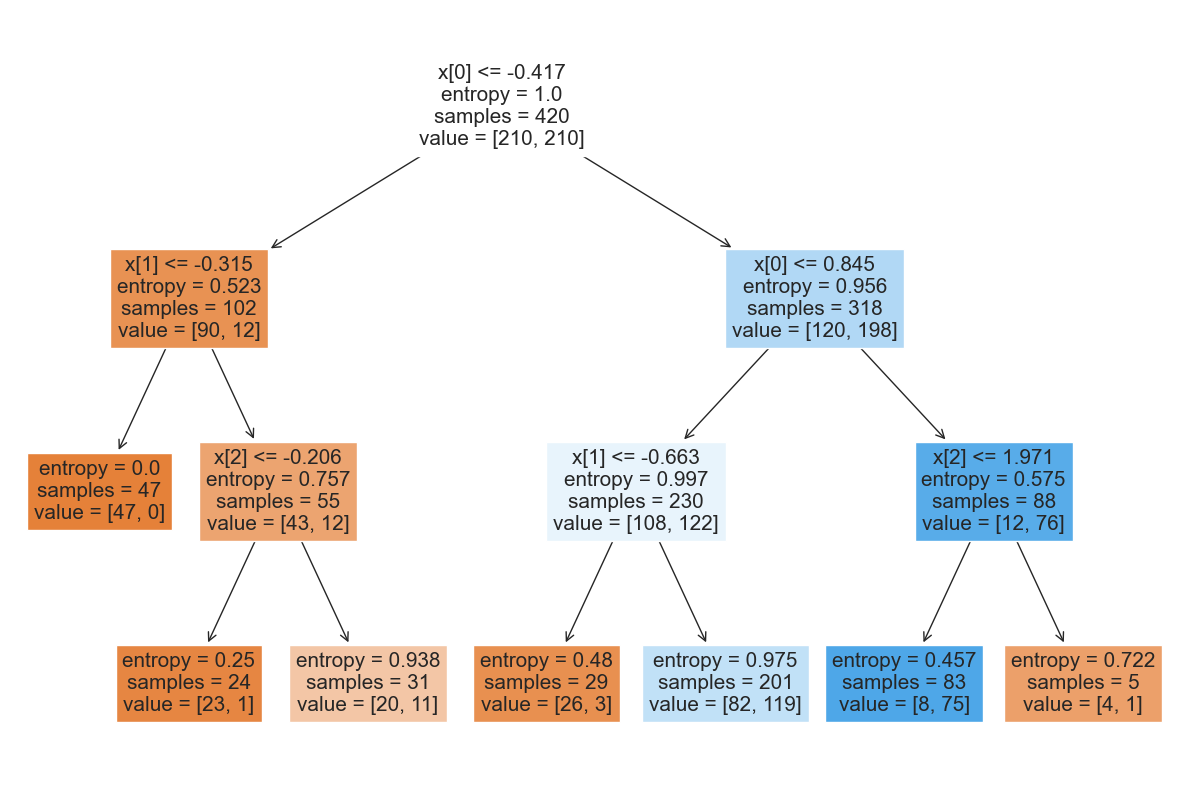

In [77]:
## Visualize the Decision Tree

plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree_model_features,filled=True)

In [78]:
# Analyze the tree structure with a code taken from Scikit Learn
n_nodes = decision_tree_model_features.tree_.node_count
children_left = decision_tree_model_features.tree_.children_left
children_right = decision_tree_model_features.tree_.children_right
feature = decision_tree_model_features.tree_.feature
threshold = decision_tree_model_features.tree_.threshold
values =decision_tree_model_features.tree_.value

## Tree structure 
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  
while len(stack) > 0:
    
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 13 nodes and has the following tree structure:

node=0 is a split node with value=[[210. 210.]]: go to node 1 if X[:, 0] <= -0.4166666716337204 else to node 6.
	node=1 is a split node with value=[[90. 12.]]: go to node 2 if X[:, 1] <= -0.31521739065647125 else to node 3.
		node=2 is a leaf node with value=[[47.  0.]].
		node=3 is a split node with value=[[43. 12.]]: go to node 4 if X[:, 2] <= -0.20588235557079315 else to node 5.
			node=4 is a leaf node with value=[[23.  1.]].
			node=5 is a leaf node with value=[[20. 11.]].
	node=6 is a split node with value=[[120. 198.]]: go to node 7 if X[:, 0] <= 0.8452380895614624 else to node 10.
		node=7 is a split node with value=[[108. 122.]]: go to node 8 if X[:, 1] <= -0.6630434989929199 else to node 9.
			node=8 is a leaf node with value=[[26.  3.]].
			node=9 is a leaf node with value=[[ 82. 119.]].
		node=10 is a split node with value=[[12. 76.]]: go to node 11 if X[:, 2] <= 1.970588207244873 else to node 12.

#### REFERENCES

Assiri, A. S., Nazir, S., & Velastin, S. A. (2020). Breast tumor classification using an ensemble machine learning method. Journal of Imaging, 6(6), 39.

Brownlee, J. (2020) a. Random oversampling and undersampling for imbalanced classification. Machine learning mastery.

Brownlee, J. (2020) b. Smote for imbalanced classification with python. Machine Learning Mastery, 16.

Heinrichs, B., & Eickhoff, S. B. (2020). Your evidence? Machine learning algorithms for medical diagnosis and prediction. Human brain mapping, 41(6), 1435-1444.

Leevy, J. L., Johnson, J. M., Hancock, J., & Khoshgoftaar, T. M. (2023). Threshold optimization and random undersampling for imbalanced credit card data. Journal of Big Data, 10(1), 58.

Lu, J., Song, E., Ghoneim, A., & Alrashoud, M. (2020). Machine learning for assisting cervical cancer diagnosis: An ensemble approach. Future Generation Computer Systems, 106, 199-205. 

Macios, A., & Nowakowski, A. (2022). False Negative Results in Cervical Cancer Screening—Risks, Reasons and Implications for Clinical Practice and Public Health. Diagnostics, 12(6), 1508.

Tarawneh, A. S., Hassanat, A. B., Altarawneh, G. A., & Almuhaimeed, A. (2022). Stop oversampling for class imbalance learning: A review. IEEE Access, 10, 47643-47660.

Yang, H., Luo, Y., Ren, X., Wu, M., He, X., Peng, B., ... & Lin, H. (2021). Risk prediction of diabetes: big data mining with fusion of multifarious physical examination indicators. Information Fusion, 75, 140-149.

8 Key Advantages and Disadvantages of Decision Trees - Inside Learning Machines. (2023, April 7). Retrieved November 30, 2023, from Inside Learning Machines website: https://insidelearningmachines.com/advantages_and_disadvantages_of_decision_trees/#:~:text=
